In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

module_path = os.path.abspath(os.path.join("../.."))
sys.path.append(module_path)

In [3]:
OUTPUT_PATH = "results/interp/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

## Dataset loading

In [4]:
from torchvision.transforms.v2 import Compose

from SLTDataset import SLTDataset
from posecraft.Pose import Pose, Component
from posecraft.transforms import (
    CenterToKeypoint,
    NormalizeDistances,
    NormalizeFramesSpeed,
    FillMissing,
    FilterLandmarks,
    RandomSampleFrames,
    ReplaceNansWithZeros,
    UseFramesDiffs,
    FlattenKeypoints,
    InterpolateFrames,
)


# DATASET = "RWTH_PHOENIX_2014T"
DATASET = "GSL"
DATA_DIR = f"/mnt/disk3Tb/slt-datasets/{DATASET}"


MAX_FRAMES = 30
LANDMARKS_USED: list[Component] = ["body", "lhand", "rhand"]  # , "face"]
USE_3D = False
LANDMARKS_MASK = Pose.get_components_mask(LANDMARKS_USED)
INPUT_MODE = "pose"
OUTPUT_MODE = "gloss"

transforms: Compose = Compose(
    [
        FilterLandmarks(LANDMARKS_MASK, USE_3D),
        # CenterToKeypoint(),
        # NormalizeDistances(indices=(11, 12), distance_factor=0.2),
        # FillMissing(),
        # InterpolateFrames(MAX_FRAMES),
        # NormalizeSpeed(max_frames=MAX_FRAMES),
        RandomSampleFrames(MAX_FRAMES),
        ReplaceNansWithZeros(),
        # UseFramesDiffs(),
        FlattenKeypoints(),
    ]
)

train_dataset = SLTDataset(
    data_dir=DATA_DIR,
    split="train",
    input_mode=INPUT_MODE,
    output_mode=OUTPUT_MODE,
    transforms=transforms,
)
val_dataset = SLTDataset(
    data_dir=DATA_DIR,
    split="val",
    input_mode=INPUT_MODE,
    output_mode=OUTPUT_MODE,
    transforms=transforms,
)
test_dataset = SLTDataset(
    data_dir=DATA_DIR,
    split="test",
    input_mode=INPUT_MODE,
    output_mode=OUTPUT_MODE,
    transforms=transforms,
)

Loaded metadata for dataset: The Greek Sign Language (GSL) Dataset
Loaded train annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 8821/8821 [00:00<00:00, 223098.32it/s]


Dataset loaded correctly

Loaded metadata for dataset: The Greek Sign Language (GSL) Dataset
Loaded val annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 588/588 [00:00<00:00, 186907.98it/s]


Dataset loaded correctly

Loaded metadata for dataset: The Greek Sign Language (GSL) Dataset
Loaded test annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 881/881 [00:00<00:00, 202364.83it/s]

Dataset loaded correctly



### Text tokenization

In [5]:
from WordLevelTokenizer import WordLevelTokenizer


texts = train_dataset.annotations[OUTPUT_MODE].tolist()
tokenizer = WordLevelTokenizer()
tokenizer.fit(texts)

print(f"Max token length: {max([len(text) for text in tokenizer(texts)])}")

Max token length: 20


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch


USE_CLASS_WEIGHTS = False
class_weights_complete = None
MAX_TOKENS = 20


if USE_CLASS_WEIGHTS:
    tokenized_sequences = tokenizer(texts, padding="max_length", max_length=25)
    flattened_tgts: list[list[int]] = [
        item for sublist in tokenized_sequences for item in sublist
    ]  # type: ignore
    token_ids = sorted(list(set(flattened_tgts)))
    class_weights = compute_class_weight(
        "balanced", classes=np.array(token_ids), y=flattened_tgts
    )
    class_weights_complete = torch.ones(tokenizer.vocab_size)
    class_weights_complete[token_ids] = torch.from_numpy(class_weights).float()

### Dataloader generation

In [7]:
import torch
from torch.utils.data import DataLoader


BATCH_SIZE = 64


def collate_fn(batch):
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    targets = tokenizer(
        targets, padding="max_length", max_length=MAX_TOKENS, return_tensors="pt"
    )
    return torch.stack(inputs), targets


NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    collate_fn=collate_fn,
)

In [8]:
for src, tgt in test_loader:
    print(src.shape)
    print(tgt.shape)
    break

torch.Size([64, 30, 150])
torch.Size([64, 20])


In [9]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib notebook

def get_update(scatter, keypoints_all_frames):
    def update(frame):
        # Reshape keypoints to have each pair (x, y) in a row
        keypoints = keypoints_all_frames[frame, :].view(-1, (3 if USE_3D else 2))
        x = keypoints[:, 0]
        y = keypoints[:, 1]
        scatter.set_offsets(torch.stack((x, y), dim=-1))
        return scatter,
    return update

def show_example(x: torch.Tensor, t: torch.Tensor, f: int = 'all', b: int = 0):
    """
    Displays keypoints as a pyplot visualization. Can show all frames as an animation or a single frame.
    Args:
    - x (torch.Tensor): Tensor of shape (B, F, L) where L is the consecutive x, y values of keypoints.
    - t (torch.Tensor): Tensor of shape (B, MAX_TOKENS) storing tokenized target sentences.
    - f (int or str): Frame index to show. Use 'all' to show all frames as an animation.
    - b (int): Batch index to visualize.
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()  # Invert y-axis so origin is at top-left

    tgt_list = [x.item() for x in tgt[b,:]]
    idx2word = tokenizer.convert_ids_to_tokens(tgt_list)
    idx2word_filtered = [word for word in idx2word if 'PAD' not in word]
    ax.set_title(" ".join(idx2word_filtered))

    scatter = ax.scatter([], [], s=10)

    keypoints_all_frames = x[b, :, :]
    func_update = get_update(scatter, keypoints_all_frames)

    if f == 'all':
        num_frames = keypoints_all_frames.shape[0]
        anim = FuncAnimation(fig, func_update, frames=num_frames, interval=50, blit=True)
        anim.save(f'{OUTPUT_PATH}/src_tgt_pose.mp4', writer='ffmpeg')
        return HTML(anim.to_jshtml())
    else:
        func_update(f)
        return fig

In [10]:
src = src.to("cpu")
tgt = tgt.to("cpu")

In [11]:
show_example(src, tgt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

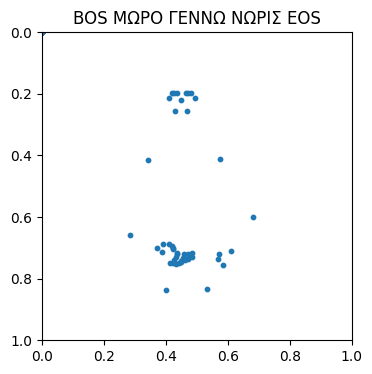

In [12]:
show_example(src, tgt, 0)

In [13]:
tgt[0, :10]

tensor([  2, 274, 189, 276,   3,   0,   0,   0,   0,   0])

In [14]:
tgt_list = list(map(lambda x: x.item(), tgt[0, :]))
tgt_list

[2, 274, 189, 276, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
idx2word = tokenizer.convert_ids_to_tokens(tgt_list)
" ".join(idx2word)

'BOS ΜΩΡΟ ΓΕΝΝΩ ΝΩΡΙΣ EOS PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'

## Model

### Definition

In [16]:
from KeypointsTransformer import KeypointsTransformer


D_MODEL = 16
NUM_ENCODER_LAYERS = 1
NUM_DECODER_LAYERS = 4
DROPOUT = 0.2

num_keypoints = LANDMARKS_MASK.sum().item()
IN_FEATURES = int(num_keypoints * (3 if USE_3D else 2))

model = KeypointsTransformer(
    src_len=MAX_FRAMES,
    tgt_len=MAX_TOKENS,
    in_features=IN_FEATURES,
    tgt_vocab_size=tokenizer.vocab_size,
    d_model=D_MODEL,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout=DROPOUT,
    interp=True,
)

/home/ostanchi/miniconda3/envs/captum/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Training

In [17]:
import lightning.pytorch.utilities.model_summary.model_summary as model_summary

from Translator import Translator
from LightningKeypointsTransformer import LKeypointsTransformer


LR = 1e-3
DEVICE = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)

BATCH_SIZE_TEST = 1
example_input_array = (
    torch.randn(BATCH_SIZE_TEST, MAX_FRAMES, IN_FEATURES),
    torch.randint(0, tokenizer.vocab_size, (BATCH_SIZE_TEST, MAX_TOKENS)),
    torch.zeros(MAX_TOKENS, MAX_TOKENS),
    torch.randint(0, 2, (BATCH_SIZE_TEST, MAX_TOKENS)).bool(),
)
translator = Translator(DEVICE, MAX_TOKENS)
l_model = LKeypointsTransformer(
    model,
    DEVICE,
    tokenizer,
    translator,
    LR,
    example_input_array,
    class_weights_complete,
)
model_summary.summarize(l_model, max_depth=10)

/home/ostanchi/miniconda3/envs/captum/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


   | Name                                                       | Type                            | Params | Mode  | In sizes                                                             | Out sizes                 
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0  | model                                                      | KeypointsTransformer            | 382 K  | train | [[1, 30, 150], [1, 20], [20, 20], [1, 20]]                           | [1, 20, 402]              
1  | model.src_keyp_emb                                         | Conv1DEmbedder                  | 21.4 K | train | [1, 30, 150]                                                         | [1, 30, 16]               
2  | model.src_keyp_emb.conv1d_1                                | Conv1d                          | 19.3 K | train | [1, 150, 30]     

In [18]:
best_model_path = (
    "checkpoints/GSL-frosty-haze-24-best-epoch=201-step=27876-val_loss=0.40.ckpt"
)

checkpoint = torch.load(best_model_path, map_location=DEVICE)["state_dict"]
adjusted_checkpoint = {}

for key, value in checkpoint.items():
    if key.startswith("model."):
        adjusted_key = key[len("model.") :]  # Elimina el prefijo 'model.'
        adjusted_checkpoint[adjusted_key] = value
    else:
        adjusted_checkpoint[key] = value

model.load_state_dict(adjusted_checkpoint)

<All keys matched successfully>

In [19]:
model = model.to(DEVICE)
model = model.eval()
src = src.to(DEVICE)
tgt = tgt.to(DEVICE)

In [20]:
BOS_IDX = tokenizer.cls_token_id
EOS_IDX = tokenizer.sep_token_id

In [21]:
translator.greedy_decode(src[:1], model, BOS_IDX, EOS_IDX)

tensor([[  2, 274, 189, 276,   3]], device='cuda:0')

In [22]:
translator.beam_decode(src[:1], model, 5, BOS_IDX, EOS_IDX)

tensor([[  2, 274, 189, 276,   3,   3]], device='cuda:0')

### Interpretability

In [23]:
idx2word = translator.translate(src[:1], model, 'greedy', tokenizer)
idx2word = ["BOS " + s + " EOS" for s in idx2word]
idx2word = idx2word[0].split()
idx2word

['BOS', 'ΜΩΡΟ', 'ΓΕΝΝΩ', 'ΝΩΡΙΣ', 'EOS']

In [24]:
# model.transformer.encoder.layers.0.self_attn
# model.transformer.decoder.layers.0.self_attn
# model.transformer.decoder.layers.0.multihead_attn

In [25]:
src[:1].shape

torch.Size([1, 30, 150])

In [26]:
model.transformer.encoder.layers[0].self_attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
)

In [27]:
multihead_attn_module = model.transformer.encoder.layers[0].self_attn
print(dir(multihead_attn_module))

['T_destination', '__annotations__', '__call__', '__class__', '__constants__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_qkv_same_embed_

#### Encoder Self-Attention

In [28]:
import seaborn as sns

attn_output_weights_list = []


def attention_hook(module, input, output):  # input: (query, key, value)
    _, attn_output_weights = output  # output: (attn_output, attn_output_weights)
    attn_output_weights_list.append(attn_output_weights[0].detach().cpu().numpy())


hook_handles = []
for layer in range(NUM_ENCODER_LAYERS):
    self_attn_module = model.transformer.encoder.layers[layer].self_attn
    hook_handles.append(self_attn_module.register_forward_hook(attention_hook))

# Inference
translator.greedy_decode(src[:1], model, BOS_IDX, EOS_IDX)

for handle in hook_handles:
    handle.remove()

fig, axes = plt.subplots(1, NUM_ENCODER_LAYERS, figsize=(10, 5), sharey=True)
for layer, attn_weights in enumerate(attn_output_weights_list):
    ax = (
        axes[layer] if NUM_ENCODER_LAYERS > 1 else axes
    )  # Handle case with only one layer
    sent = np.arange(MAX_FRAMES)
    sns.heatmap(
        attn_weights,
        ax=ax,
        xticklabels=sent,
        yticklabels=sent,
        square=True,
        cbar=False,
    )  # vmin=0.0, vmax=1.0)
    ax.set_title(f"Layer {layer+1}")

plt.savefig(f"{OUTPUT_PATH}/attn_self_heatmaps_encoder_layers.png")
plt.show()

<IPython.core.display.Javascript object>

In [29]:
len(attn_output_weights_list)

1

#### Decoder Self-Attention

In [30]:
sum(1 for x in tgt_list if x != 0)

5

In [31]:
def reorganize_list(input_list, N):
    grouped_list = []
    for i in range(N):
        grouped_list.extend(input_list[i::N])
    return grouped_list

In [32]:
import seaborn as sns

attn_output_weights_list = []


def attention_hook(module, input, output):  # input: (query, key, value)
    _, attn_output_weights = output  # output: (attn_output, attn_output_weights)
    print(output[0].shape, output[1].shape)
    attn_output_weights_list.append(attn_output_weights[0].detach().cpu().numpy())


hook_handles = []
for layer in range(NUM_DECODER_LAYERS):
    self_attn_module = model.transformer.decoder.layers[layer].self_attn
    hook_handles.append(self_attn_module.register_forward_hook(attention_hook))

# Inference
translator.greedy_decode(src[:1], model, BOS_IDX, EOS_IDX)

for handle in hook_handles:
    handle.remove()

rows = sum(1 for x in tgt_list if x != 0) - 1  # from BOS to EOS-1
fig, axes = plt.subplots(rows, NUM_DECODER_LAYERS, figsize=(20, 20), sharey=True)
attn_output_weights_list = reorganize_list(attn_output_weights_list, NUM_DECODER_LAYERS)
for layer, attn_weights in enumerate(attn_output_weights_list):
    i, j = divmod(layer, rows)
    print(i, j, layer)
    ax = axes[j, i]
    tgt_sent = idx2word[1 : attn_weights.shape[0] + 1]
    sns.heatmap(
        attn_weights,
        ax=ax,
        xticklabels=tgt_sent,
        yticklabels=tgt_sent,
        square=True,
        cbar=False,
    )  # vmin=0.0, vmax=1.0)
    ax.set_yticklabels(tgt_sent, rotation=0)
    ax.set_xticklabels(tgt_sent, rotation=90)
    ax.set_title(f"Layer {i+1}") if layer % rows == 0 else None

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.savefig(f"{OUTPUT_PATH}/attn_self_heatmaps_decoder_layers.png", dpi=150)
plt.show()

torch.Size([1, 1, 16]) torch.Size([1, 1, 1])
torch.Size([1, 1, 16]) torch.Size([1, 1, 1])
torch.Size([1, 1, 16]) torch.Size([1, 1, 1])
torch.Size([1, 1, 16]) torch.Size([1, 1, 1])
torch.Size([1, 2, 16]) torch.Size([1, 2, 2])
torch.Size([1, 2, 16]) torch.Size([1, 2, 2])
torch.Size([1, 2, 16]) torch.Size([1, 2, 2])
torch.Size([1, 2, 16]) torch.Size([1, 2, 2])
torch.Size([1, 3, 16]) torch.Size([1, 3, 3])
torch.Size([1, 3, 16]) torch.Size([1, 3, 3])
torch.Size([1, 3, 16]) torch.Size([1, 3, 3])
torch.Size([1, 3, 16]) torch.Size([1, 3, 3])
torch.Size([1, 4, 16]) torch.Size([1, 4, 4])
torch.Size([1, 4, 16]) torch.Size([1, 4, 4])
torch.Size([1, 4, 16]) torch.Size([1, 4, 4])
torch.Size([1, 4, 16]) torch.Size([1, 4, 4])


<IPython.core.display.Javascript object>

0 0 0
0 1 1
0 2 2
0 3 3
1 0 4
1 1 5
1 2 6
1 3 7
2 0 8
2 1 9
2 2 10
2 3 11
3 0 12
3 1 13
3 2 14
3 3 15


In [33]:
len(attn_output_weights_list)

16

#### Decoder Cross-Attention

In [34]:
import seaborn as sns

attn_output_weights_list = []


def attention_hook(module, input, output):  # input: (query, key, value)
    _, attn_output_weights = output  # output: (attn_output, attn_output_weights)
    print(output[0].shape, output[1].shape)
    attn_output_weights_list.append(attn_output_weights[0].detach().cpu().numpy())


hook_handles = []
for layer in range(NUM_DECODER_LAYERS):
    multihead_attn_module = model.transformer.decoder.layers[layer].multihead_attn
    hook_handles.append(multihead_attn_module.register_forward_hook(attention_hook))

# Inference
translator.greedy_decode(src[:1], model, BOS_IDX, EOS_IDX)

for handle in hook_handles:
    handle.remove()

rows = sum(1 for x in tgt_list if x != 0) - 1  # from BOS to EOS-1
fig, axes = plt.subplots(rows, NUM_DECODER_LAYERS, figsize=(20, 20), sharey=True)
attn_output_weights_list = reorganize_list(attn_output_weights_list, NUM_DECODER_LAYERS)
for layer, attn_weights in enumerate(attn_output_weights_list):
    i, j = divmod(layer, rows)
    print(i, j, layer)
    ax = axes[j, i]
    sent = np.arange(MAX_FRAMES)
    tgt_sent = idx2word[1 : attn_weights.shape[0] + 1]
    sns.heatmap(
        attn_weights,
        ax=ax,
        xticklabels=sent,
        yticklabels=tgt_sent,
        square=True,
        cbar=False,
    )  # vmin=0.0, vmax=1.0)
    ax.set_aspect("auto")
    ax.set_yticklabels(tgt_sent, rotation=0)
    ax.set_xticklabels(sent, rotation=90)
    ax.set_title(f"Layer {i+1}") if layer % rows == 0 else None

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.savefig(f"{OUTPUT_PATH}/attn_cross_heatmaps_decoder_layers.png", dpi=150)
plt.show()

torch.Size([1, 1, 16]) torch.Size([1, 1, 30])
torch.Size([1, 1, 16]) torch.Size([1, 1, 30])
torch.Size([1, 1, 16]) torch.Size([1, 1, 30])
torch.Size([1, 1, 16]) torch.Size([1, 1, 30])
torch.Size([1, 2, 16]) torch.Size([1, 2, 30])
torch.Size([1, 2, 16]) torch.Size([1, 2, 30])
torch.Size([1, 2, 16]) torch.Size([1, 2, 30])
torch.Size([1, 2, 16]) torch.Size([1, 2, 30])
torch.Size([1, 3, 16]) torch.Size([1, 3, 30])
torch.Size([1, 3, 16]) torch.Size([1, 3, 30])
torch.Size([1, 3, 16]) torch.Size([1, 3, 30])
torch.Size([1, 3, 16]) torch.Size([1, 3, 30])
torch.Size([1, 4, 16]) torch.Size([1, 4, 30])
torch.Size([1, 4, 16]) torch.Size([1, 4, 30])
torch.Size([1, 4, 16]) torch.Size([1, 4, 30])
torch.Size([1, 4, 16]) torch.Size([1, 4, 30])


<IPython.core.display.Javascript object>

0 0 0
0 1 1
0 2 2
0 3 3
1 0 4
1 1 5
1 2 6
1 3 7
2 0 8
2 1 9
2 2 10
2 3 11
3 0 12
3 1 13
3 2 14
3 3 15
